# MLM under markovia assumption violation 

In [1]:
%load_ext autoreload
%autoreload 2

import markovlink
import numpy as np
import numpy.random as npr
import scipy as sp
import pickle
import matplotlib.pylab as plt
import sys
import matplotlib
import pandas as pd
from markovlink import simulations

# lets first check the sensitivity of our simulations
- we start from varying $\Delta$, which is defined as the violatoin to the markovian assumptions
- then we add this to the simulated P(Y|X) to generated "*viloated*" $P'(P|X,L=l) = P(Y|X)+\Delta_l$ - note we cannot guarantee P'(Y|X,L=l) is probablity
- project P' back to simplex -> $P(Y|X,L=l)$ which is probablity 
    - (we have two mechanisms of doing this) 
- re-calculate the differences $\Delta'=P(Y|X,L=l)-P(Y|X)$
- actually $\Delta$ is hard interpret, so we compute the total variation between above insteasd 
- and we do this with varying $\Delta, N_X, N_Y$

In [2]:
rng = np.random.default_rng(42)
deltas = np.linspace(0, 10, 50)

Text(0.75, 0.95, 'num_X=30, num_Y=40')

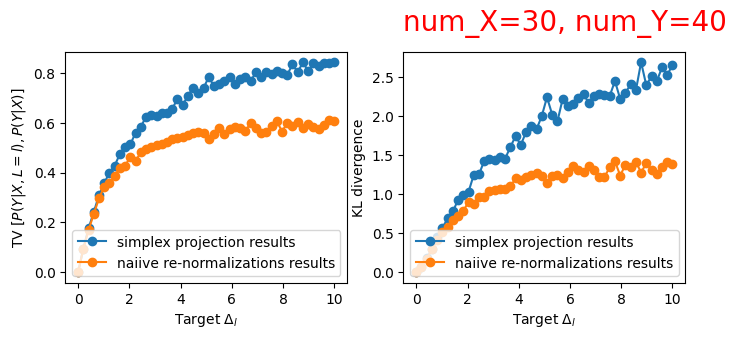

In [3]:
num_X, num_Y = 30,40
PY_X = rng.dirichlet(np.ones(num_Y), size=num_X)
tv_vals_1 = []; tv_vals_2 = []
kl_vals_1 = []; kl_vals_2 = []
for d in deltas:
    P_new_1 = simulations.generate_violations_project(PY_X, d, rng)  # baically  (X, Y) 
    P_new_2 = simulations.generate_violations_clip(PY_X, d, rng)
    
    tv_1 = np.abs(P_new_1-PY_X).sum()/(2*num_X)
    kl_1 = np.sum(P_new_1 * np.log(P_new_1 / PY_X), axis=1).mean()
    tv_vals_1.append(tv_1)
    kl_vals_1.append(kl_1)
    
    tv_2 = np.abs(P_new_2-PY_X).sum()/(2*num_X)
    kl_2 = np.sum(P_new_2 * np.log(P_new_2 / PY_X), axis=1).mean()
    tv_vals_2.append(tv_2)
    kl_vals_2.append(kl_2)
    
fig = plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.plot(deltas, tv_vals_1, marker='o', label='simplex projection results')
plt.plot(deltas, tv_vals_2, marker='o', label='naiive re-normalizations results')
plt.legend()
plt.xlabel("Target $\Delta_l$")
plt.ylabel("TV [$P(Y|X,L=l), P(Y|X)$]")
plt.subplot(1,2,2)
plt.plot(deltas, kl_vals_1, marker='o', label='simplex projection results')
plt.plot(deltas, kl_vals_2, marker='o', label='naiive re-normalizations results')
plt.legend()
plt.xlabel("Target $\Delta_l$")
plt.ylabel("KL divergence")
fig.text(0.75, 0.95, f'num_X={num_X}, num_Y={num_Y}',ha='center', fontsize=20, color = 'red')


Text(0.75, 0.95, 'num_X=5, num_Y=10')

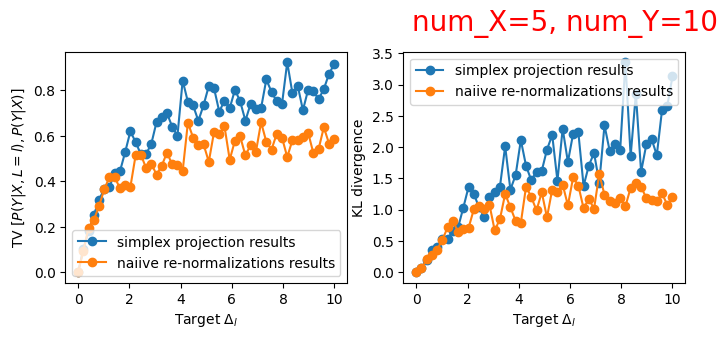

In [4]:
num_X, num_Y = 5,10
PY_X = rng.dirichlet(np.ones(num_Y), size=num_X)
tv_vals_1 = []; tv_vals_2 = []
kl_vals_1 = []; kl_vals_2 = []
for d in deltas:
    P_new_1 = simulations.generate_violations_project(PY_X, d, rng)  # baically  (X, Y) 
    P_new_2 = simulations.generate_violations_clip(PY_X, d, rng)
    
    tv_1 = np.abs(P_new_1-PY_X).sum()/(2*num_X)
    kl_1 = np.sum(P_new_1 * np.log(P_new_1 / PY_X), axis=1).mean()
    tv_vals_1.append(tv_1)
    kl_vals_1.append(kl_1)
    
    tv_2 = np.abs(P_new_2-PY_X).sum()/(2*num_X)
    kl_2 = np.sum(P_new_2 * np.log(P_new_2 / PY_X), axis=1).mean()
    tv_vals_2.append(tv_2)
    kl_vals_2.append(kl_2)
    
fig = plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(deltas, tv_vals_1, marker='o', label='simplex projection results')
plt.plot(deltas, tv_vals_2, marker='o', label='naiive re-normalizations results')
plt.legend()
plt.xlabel("Target $\Delta_l$")
plt.ylabel("TV [$P(Y|X,L=l), P(Y|X)$]")
plt.subplot(1,2,2)
plt.plot(deltas, kl_vals_1, marker='o', label='simplex projection results')
plt.plot(deltas, kl_vals_2, marker='o', label='naiive re-normalizations results')
plt.legend()
plt.xlabel("Target $\Delta_l$")
plt.ylabel("KL divergence")
fig.text(0.75, 0.95, f'num_X={num_X}, num_Y={num_Y}',ha='center', fontsize=20, color = 'red')


--> so the simulation is reasonable, when increasing $\Delta$ we reasonably increase violation of markov assumptions

# simulate the distributions P(Y|X,L) with varying $\Delta$
we evaluate two things
1. MAP estimate of the $\hat P(Y|X) $
2. if GT $P(Y|X)$ falls in between the confidence intervals


for 2, we can run one time. for 1, i think we want to run multiple simulatiosn (so simulate a lot of cases with the given Delta)

In [5]:
rng = np.random.default_rng(42)
num_X = 3  
num_L = 5
num_Y = 4 

PX = rng.dirichlet(np.ones(num_X))  # P(X) 
PL = rng.dirichlet(np.ones(num_L))  # P(L)
PY_X = rng.dirichlet(np.ones(num_Y), size=num_X)  # P(Y|X): GT
PL_X_raw = rng.uniform(0.1, 0.9, size=(num_X, num_L))  # Raw probabilities
PL_X = PL_X_raw / np.sum(PL_X_raw, axis=1, keepdims=True)  # Normalize to sum to 1
PXY = PY_X * PX[:, None]  # joint|
Delta_values = [0,1,4, 10,20,50] 
PY_XL_dict = simulations.generate_violations(PY_X, Delta_values, num_L, rng)

In [7]:
n_samples = 10000  # number of observations in X  and Y, to estimate the conditional (P(X|L) and P(Y|L))
results = []
for delta, PY_XL in PY_XL_dict.items():    
    PX_L = PL_X.T / np.sum(PL_X, 0)[:,None] # denominator is P(L) 
    PY_L = np.zeros((num_L, num_Y))
    for l in range(num_L):
        for y in range(num_Y):
            PY_L[l, y] = np.sum(PY_XL[:, y, l] * PX_L[l])  # sum over X
    Nlx = np.array([npr.multinomial(n_samples, px) for px in PX_L])  # num_L x num_X, integers
    Nly = np.array([npr.multinomial(n_samples, py) for py in PY_L]) # num_L x num_Y
    PY_X_hat, CIs = markovlink.estimates(Nlx, Nly, nsamps=50, verbose=False)
    accuracy = simulations.evaluate_estimation_accuracy(PY_X, PY_X_hat, f"MLM_delta_{delta}")
    accuracy['delta'] = delta
    results.append(accuracy)
df_results = pd.DataFrame(results)    
df_results

,method,tv_distance,frobenius,max_error,mse,delta
0,MLM_delta_0,0.017818,0.037269,0.020699,0.000116,0
1,MLM_delta_1,0.104342,0.232803,0.148640,0.004516,1
2,MLM_delta_4,0.490205,0.976408,0.459280,0.079448,4
3,MLM_delta_10,0.256417,0.562724,0.347754,0.026388,10
4,MLM_delta_20,0.478859,1.005947,0.523667,0.084327,20
5,MLM_delta_50,0.368492,0.817048,0.457950,0.055631,50


# evaluate the MLM MAP estimate

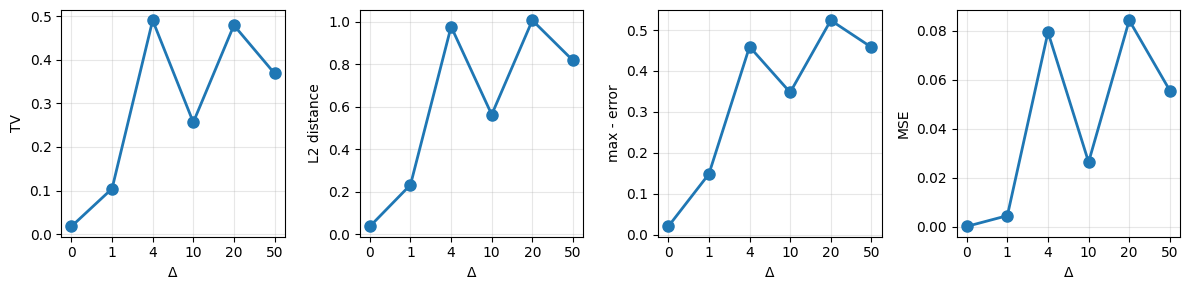

In [8]:
fig, axes = plt.subplots(1,4, figsize=(12,3))    
metrics = ['tv_distance', 'frobenius', 'max_error', 'mse']
titles = ['TV', 'L2 distance', 'max - error', 'MSE']
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    ax.plot((df_results['delta']).astype(str), df_results[metric], 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('$\Delta$')
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


--> honeslty its really hard to see any trends with one simulation here!

# check CIs estimate (how many times the GT is within CI range?)

Delta 0: 1.000 coverage (12/12 parameters)
Delta 1: 1.000 coverage (12/12 parameters)
Delta 4: 0.917 coverage (11/12 parameters)
Delta 10: 1.000 coverage (12/12 parameters)
Delta 20: 0.917 coverage (11/12 parameters)
Delta 50: 0.917 coverage (11/12 parameters)


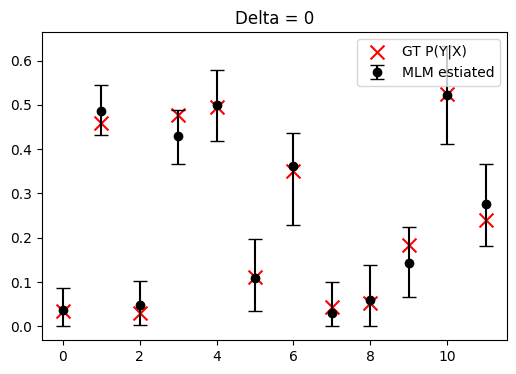

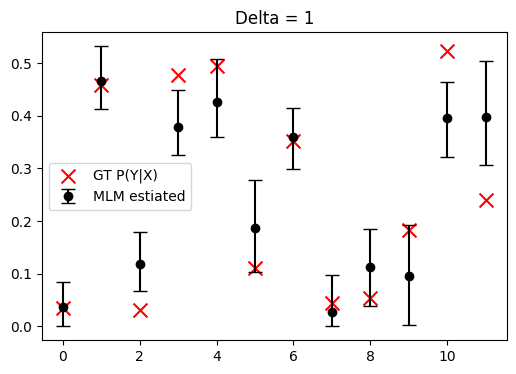

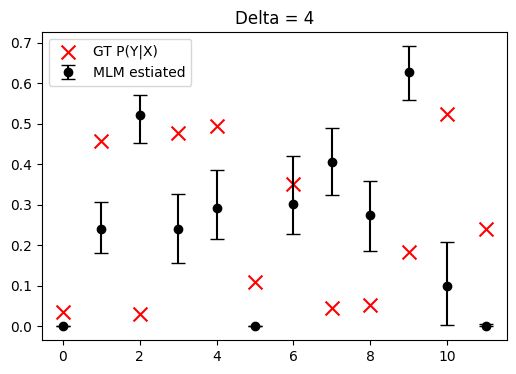

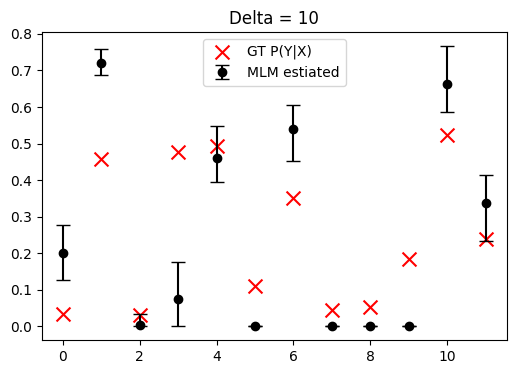

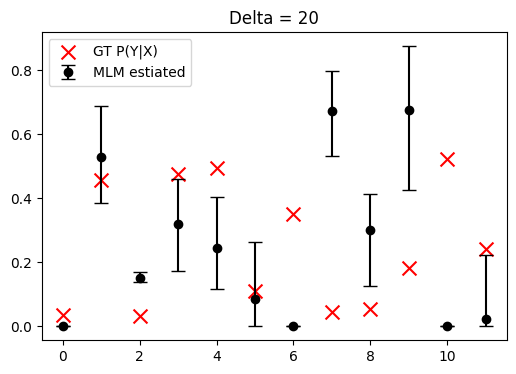

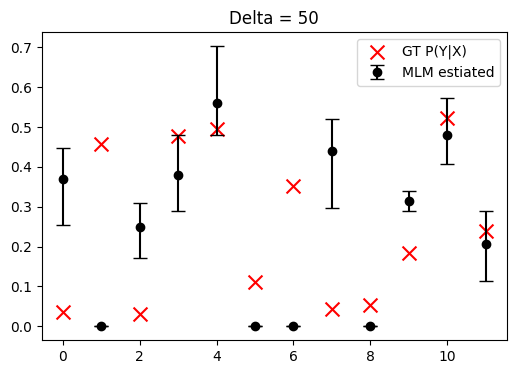

In [9]:
coverage_results = []
for delta in Delta_values:
    PY_XL = PY_XL_dict[delta]    
    n_samples = 1000
    PX_L = PL_X.T / PL_X.T.sum(axis=1, keepdims=True)  # Normalize to ensure proper probabilities
    PY_L = np.zeros((num_L, num_Y))
    for l in range(num_L):
        for y in range(num_Y):
            PY_L[l, y] = np.sum(PY_XL[:, y, l] * PX_L[l])  # Sum over X: P(Y=y|L=l) = Σ_x P(Y=y|X=x,L=l) * P(X=x|L=l)
    Nlx = np.array([npr.multinomial(n_samples, px) for px in PX_L])
    Nly = np.array([npr.multinomial(n_samples, py) for py in PY_L])

    qhat, CIs = markovlink.estimates(Nlx, Nly, nsamps=50, alpha=0.05, verbose=False)
    vec1 = CIs[...,1].flatten(); vec2 = CIs[...,0].flatten()
    vec3 = PY_X.flatten()
    x = np.arange(len(qhat.flatten()))
    yerr = np.vstack([
    np.maximum(qhat.flatten() - vec2, 0),
    np.maximum(vec1 - qhat.flatten(), 0)
])

    plt.figure(figsize = (6,4))
    plt.errorbar(x, qhat.flatten(), yerr=yerr, fmt='o', capsize=5, color='k', label='MLM estiated')
    plt.scatter(x,vec3,color = 'r', marker = 'x', s = 100,label='GT P(Y|X)')
    plt.legend(); plt.title(f'Delta = {delta}')
    
    within_CI = (qhat >= CIs[:, :, 0]) & (qhat <= CIs[:, :, 1])
    coverage_rate = np.mean(within_CI)        
    coverage_results.append({
        'delta': delta,
        'coverage_rate': coverage_rate,
        'expected_coverage': 0.95,
        'total_params': within_CI.size,
        'covered_params': within_CI.sum()})
    print(f"Delta {delta}: {coverage_rate:.3f} coverage ({within_CI.sum()}/{within_CI.size} parameters)")


# now lets do A LOT of simualtions and get a variance for our MAP estimate 

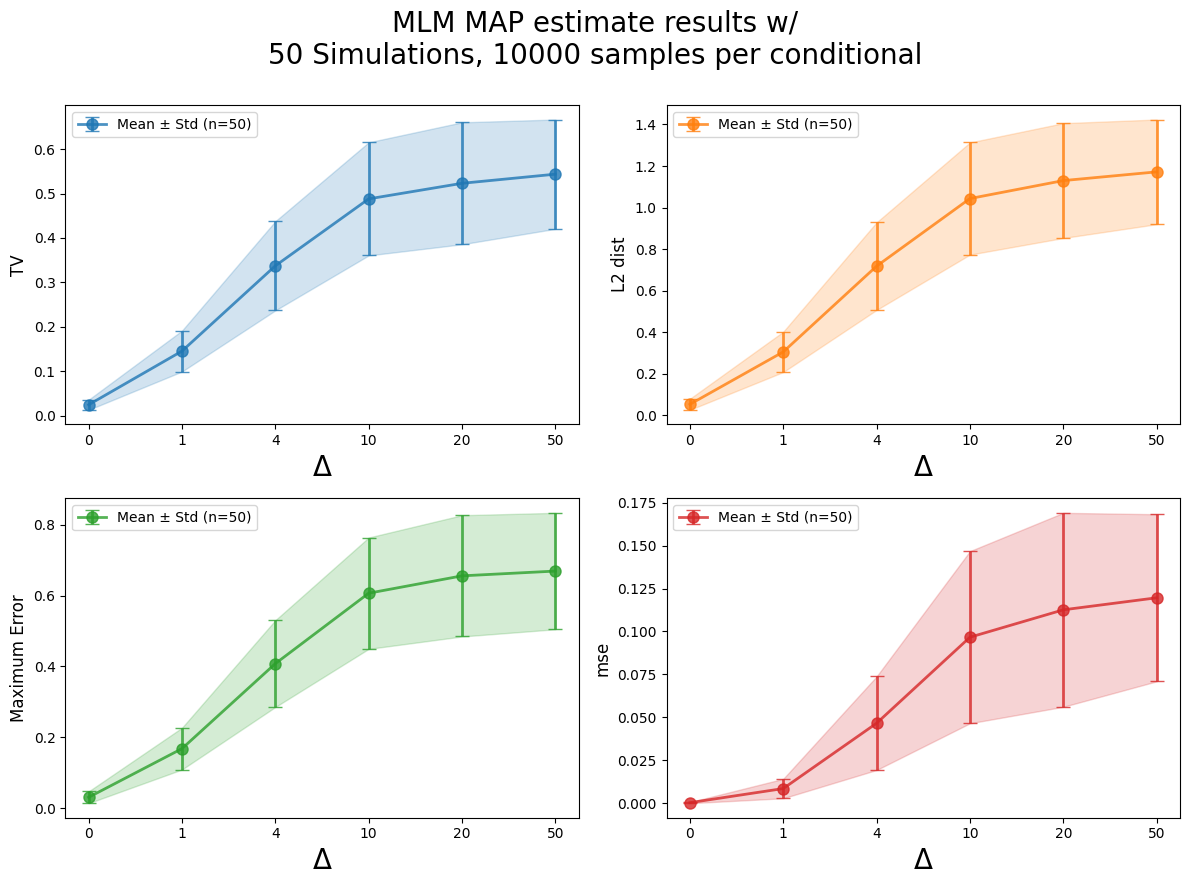

In [21]:
# these are fixed values
num_simu = 50  # Number of simulation runs

rng = np.random.default_rng(42)
num_X = 3  
num_L = 5
num_Y = 4 
Delta_values = [0,1,4, 10,20,50] 
n_samples = 10000  # number of observations in X  and Y, to estimate the conditional (P(X|L) and P(Y|L))
all_simulation_results = []

for sim_idx in range(num_simu):
    if (sim_idx + 1) % 10 == 0:
        print(f" {sim_idx + 1}/{num_simu} simulations")
    sim_rng = np.random.default_rng(42 + sim_idx)
    
    # simulate the data first 
    PX = rng.dirichlet(np.ones(num_X))  # P(X) 
    PL = rng.dirichlet(np.ones(num_L))  # P(L)
    PY_X = rng.dirichlet(np.ones(num_Y), size=num_X)  # P(Y|X): GT
    PL_X_raw = rng.uniform(0.1, 0.9, size=(num_X, num_L))  # Raw probabilities
    PL_X = PL_X_raw / np.sum(PL_X_raw, axis=1, keepdims=True)  # Normalize to sum to 1
    PXY = PY_X * PX[:, None]  # joint|
    PY_XL_dict = simulations.generate_violations(PY_X, Delta_values, num_L, rng)

    sim_results = []
    for delta, PY_XL in PY_XL_dict.items():    
        PX_L = PL_X.T / np.sum(PL_X, 0)[:,None] # denominator is P(L) 
        PY_L = np.zeros((num_L, num_Y))
        for l in range(num_L):
            for y in range(num_Y):
                PY_L[l, y] = np.sum(PY_XL[:, y, l] * PX_L[l])  # sum over X
        Nlx = np.array([sim_rng.multinomial(n_samples, px) for px in PX_L])  # num_L x num_X, integers
        Nly = np.array([sim_rng.multinomial(n_samples, py) for py in PY_L]) # num_L x num_Y
        PY_X_hat, CIs = markovlink.estimates(Nlx, Nly, nsamps=50, verbose=False)
        accuracy = simulations.evaluate_estimation_accuracy(PY_X, PY_X_hat, f"MLM_delta_{delta}")
        accuracy['delta'] = delta
        accuracy['simulation_idx'] = sim_idx
        sim_results.append(accuracy)
    all_simulation_results.extend(sim_results)
print(f"Completed all {num_simu} simulations!")

df_summary = simulations.get_performance_stats(all_simulation_results, Delta_values)


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

metrics = ['tv_distance', 'frobenius', 'max_error', 'mse']
titles = ['TV', 'L2 dist', 'Maximum Error', 'mse']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[i]
    x_vals = df_summary['delta'].values.astype(str)
    y_means = df_summary[f'{metric}_mean'].values
    y_stds = df_summary[f'{metric}_std'].values
    ax.errorbar(x_vals, y_means, yerr=y_stds, 
                fmt='o-', linewidth=2, markersize=8, capsize=5,
                color=color, ecolor=color, alpha=0.8,
                label=f'Mean ± Std (n={num_simu})')
    ax.fill_between(x_vals, y_means - y_stds, y_means + y_stds, 
                    alpha=0.2, color=color)

    ax.set_xlabel('$\Delta$', fontsize=20)
    ax.set_ylabel(title, fontsize=12)
    ax.legend()
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels([str(int(d)) for d in x_vals])

plt.tight_layout()
plt.suptitle(f'MLM MAP estimate results w/\n{num_simu} Simulations, {n_samples} samples per conditional', 
             fontsize=20, y=1.1)
plt.show()

# how about when the sample num is smaller ? 

 10/50 simulations
 20/50 simulations
 30/50 simulations
 40/50 simulations
 50/50 simulations
Completed all 50 simulations!


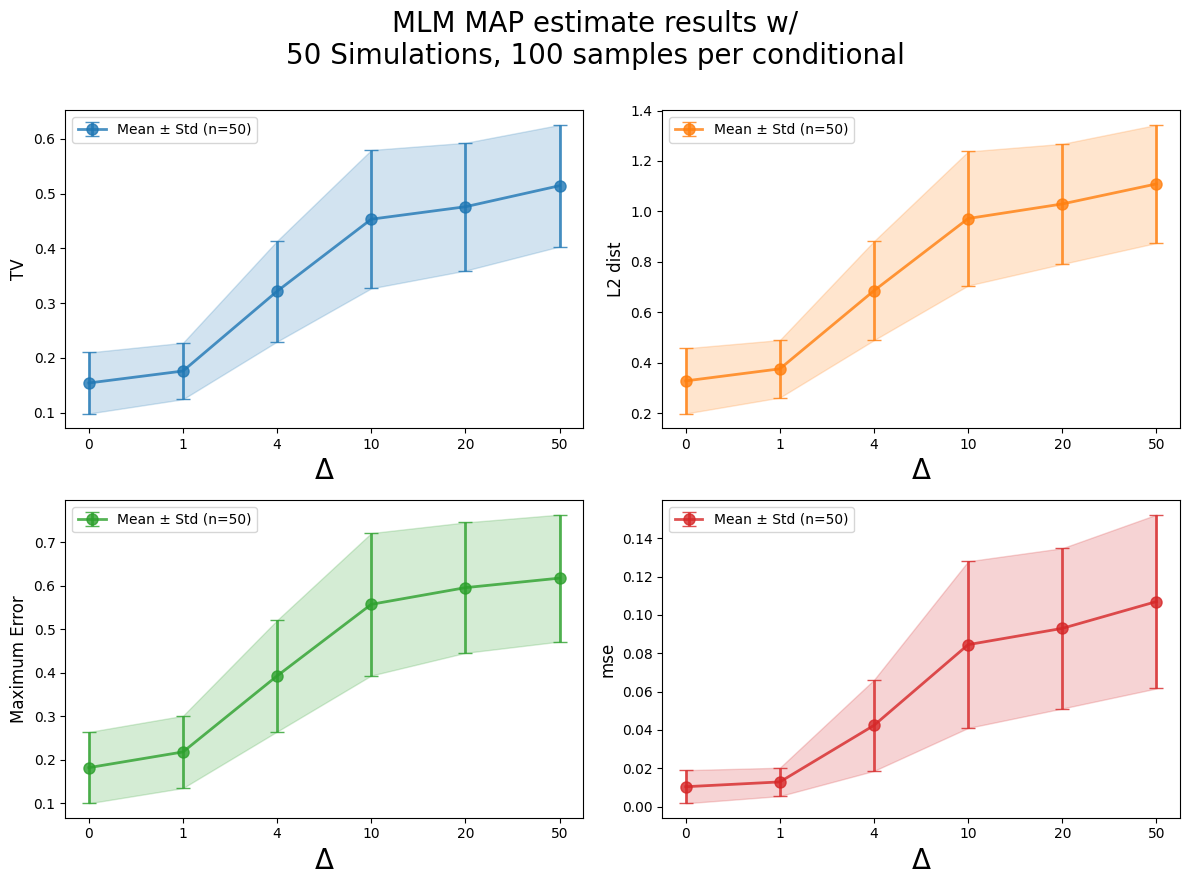

In [23]:
# these are fixed values
num_simu = 50  # Number of simulation runs
n_samples = 100  # number of observations in X  and Y, to estimate the conditional (P(X|L) and P(Y|L))
all_simulation_results = []

for sim_idx in range(num_simu):
    if (sim_idx + 1) % 10 == 0:
        print(f" {sim_idx + 1}/{num_simu} simulations")
    sim_rng = np.random.default_rng(42 + sim_idx)
    
    # simulate the data first 
    PX = rng.dirichlet(np.ones(num_X))  # P(X) 
    PL = rng.dirichlet(np.ones(num_L))  # P(L)
    PY_X = rng.dirichlet(np.ones(num_Y), size=num_X)  # P(Y|X): GT
    PL_X_raw = rng.uniform(0.1, 0.9, size=(num_X, num_L))  # Raw probabilities
    PL_X = PL_X_raw / np.sum(PL_X_raw, axis=1, keepdims=True)  # Normalize to sum to 1
    PXY = PY_X * PX[:, None]  # joint|
    PY_XL_dict = simulations.generate_violations(PY_X, Delta_values, num_L, rng)

    sim_results = []
    for delta, PY_XL in PY_XL_dict.items():    
        PX_L = PL_X.T / np.sum(PL_X, 0)[:,None] # denominator is P(L) 
        PY_L = np.zeros((num_L, num_Y))
        for l in range(num_L):
            for y in range(num_Y):
                PY_L[l, y] = np.sum(PY_XL[:, y, l] * PX_L[l])  # sum over X
        Nlx = np.array([sim_rng.multinomial(n_samples, px) for px in PX_L])  # num_L x num_X, integers
        Nly = np.array([sim_rng.multinomial(n_samples, py) for py in PY_L]) # num_L x num_Y
        PY_X_hat, CIs = markovlink.estimates(Nlx, Nly, nsamps=50, verbose=False)
        accuracy = simulations.evaluate_estimation_accuracy(PY_X, PY_X_hat, f"MLM_delta_{delta}")
        accuracy['delta'] = delta
        accuracy['simulation_idx'] = sim_idx
        sim_results.append(accuracy)
    all_simulation_results.extend(sim_results)
print(f"Completed all {num_simu} simulations!")

df_summary = simulations.get_performance_stats(all_simulation_results, Delta_values)


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

metrics = ['tv_distance', 'frobenius', 'max_error', 'mse']
titles = ['TV', 'L2 dist', 'Maximum Error', 'mse']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[i]
    x_vals = df_summary['delta'].values.astype(str)
    y_means = df_summary[f'{metric}_mean'].values
    y_stds = df_summary[f'{metric}_std'].values
    ax.errorbar(x_vals, y_means, yerr=y_stds, 
                fmt='o-', linewidth=2, markersize=8, capsize=5,
                color=color, ecolor=color, alpha=0.8,
                label=f'Mean ± Std (n={num_simu})')
    ax.fill_between(x_vals, y_means - y_stds, y_means + y_stds, 
                    alpha=0.2, color=color)

    ax.set_xlabel('$\Delta$', fontsize=20)
    ax.set_ylabel(title, fontsize=12)
    ax.legend()
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels([str(int(d)) for d in x_vals])

plt.tight_layout()
plt.suptitle(f'MLM MAP estimate results w/\n{num_simu} Simulations, {n_samples} samples per conditional', 
             fontsize=20, y=1.1)
plt.show()

# visualize some cases 
TODO: change the delta to be much smaller. 

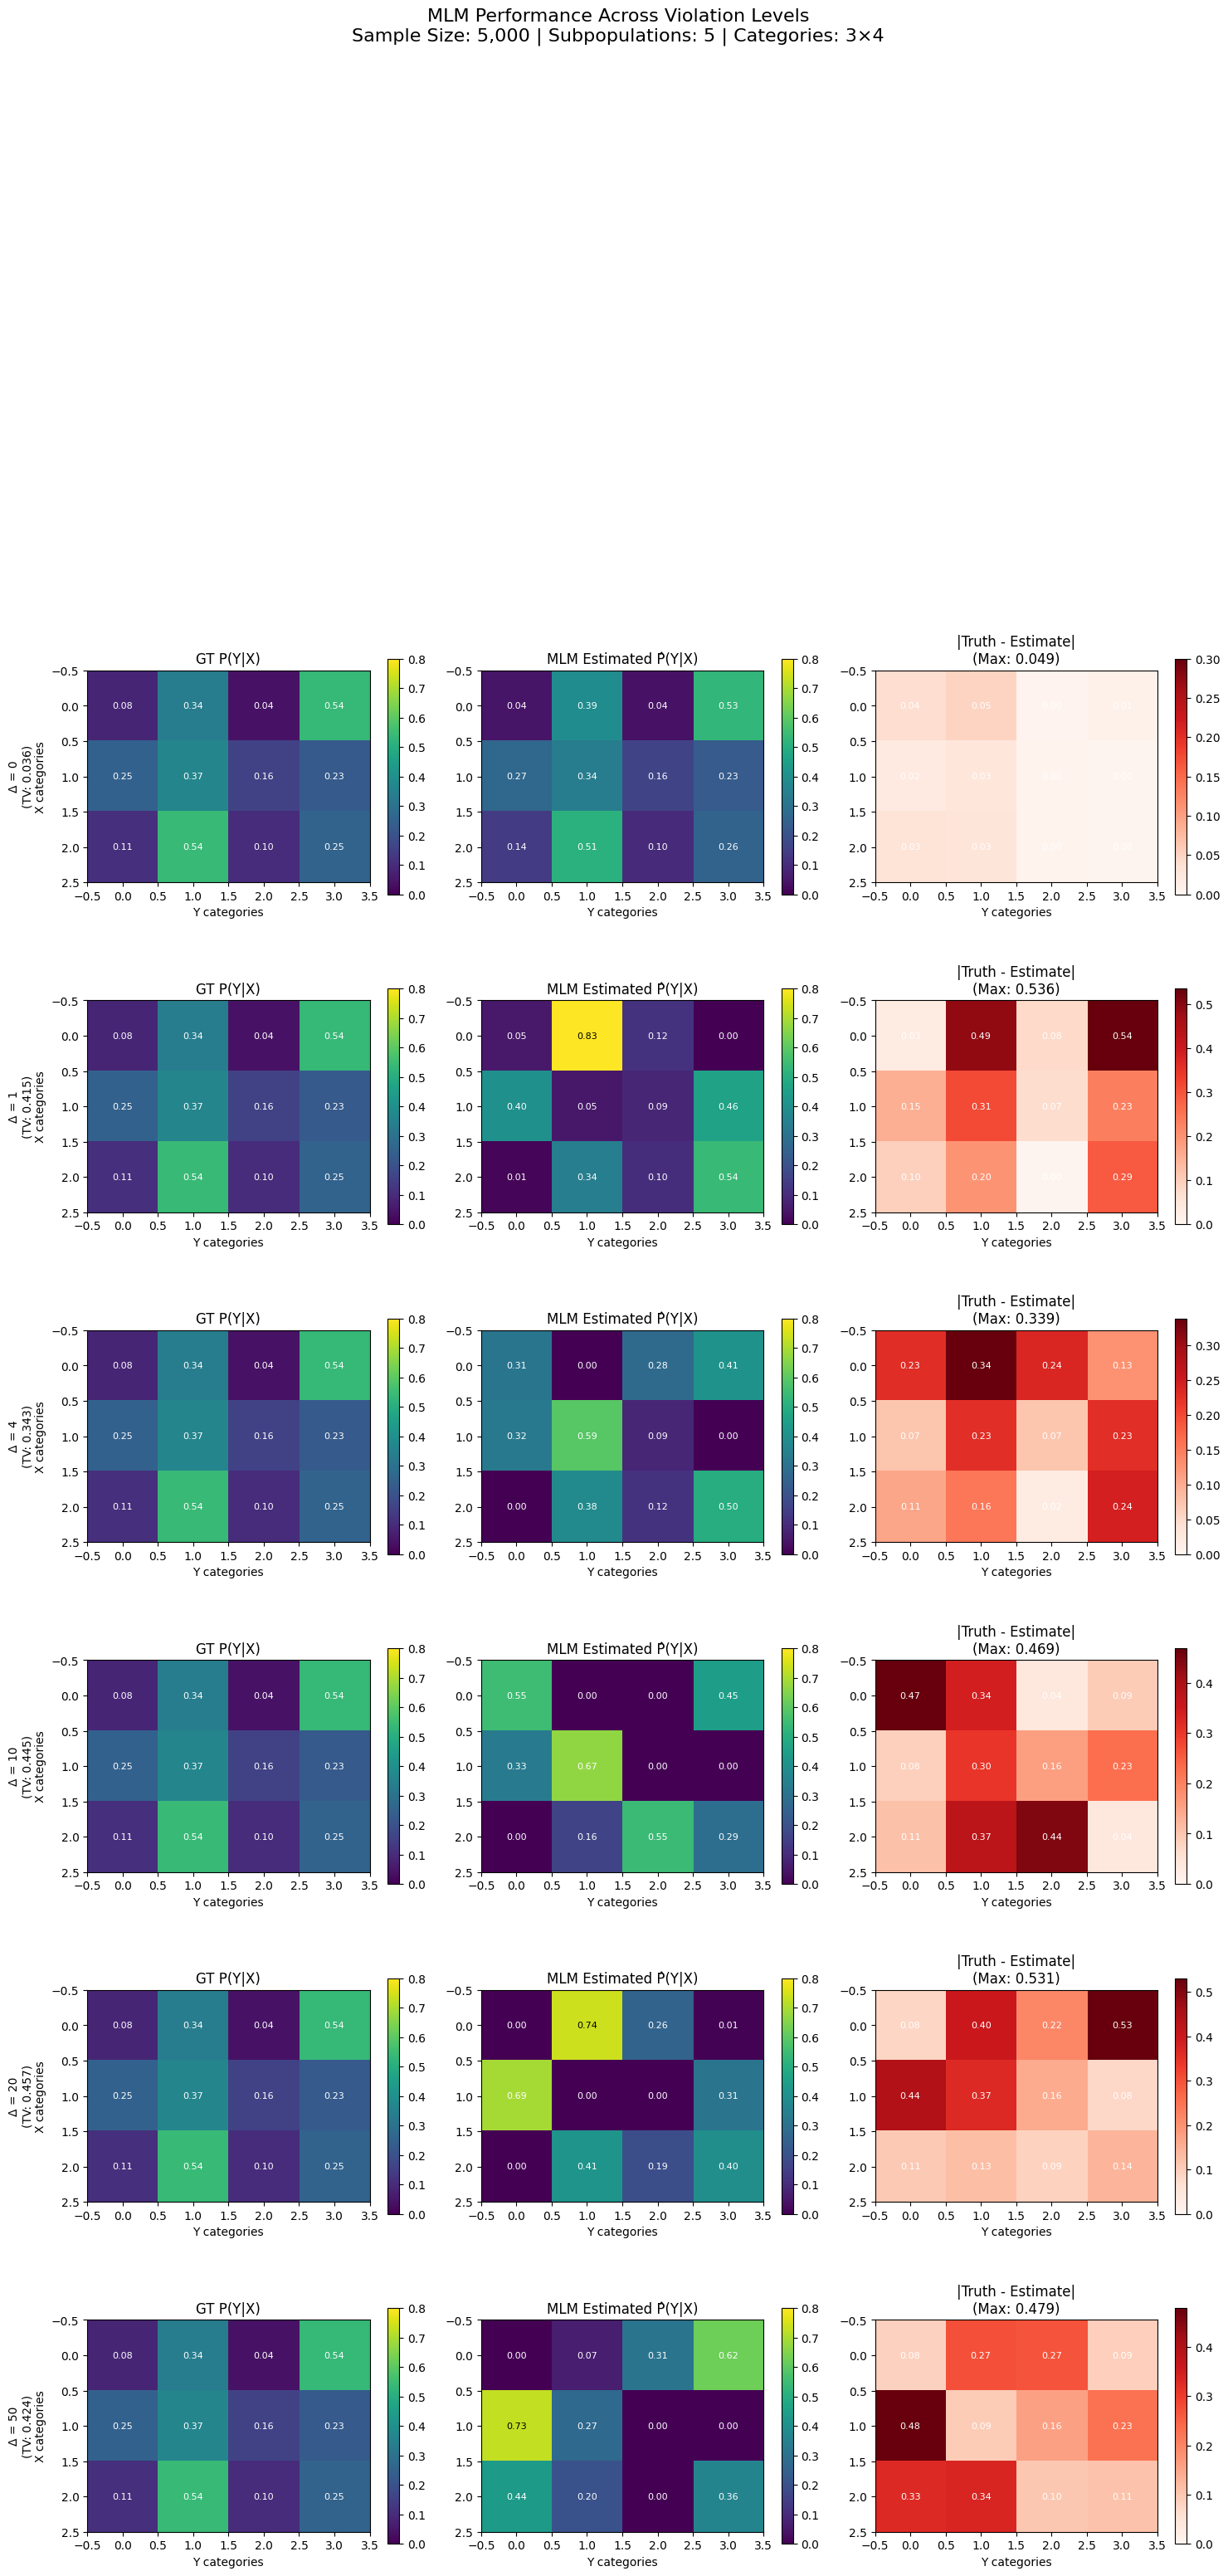

In [31]:

n_samples_viz = 5000  # Sample size for visualization (balance between speed and accuracy)
fig, axes = plt.subplots(len(Delta_values), 3, figsize=(15, 4*len(Delta_values)))
if len(Delta_values) == 1:
    axes = axes.reshape(1, -1)
for i, delta in enumerate(Delta_values):
    PY_XL = PY_XL_dict[delta]
    PX_L = PL_X.T / np.sum(PL_X, 0)[:,None]  # P(X|L) for each subpopulation
    PY_L = np.zeros((num_L, num_Y))
    for l in range(num_L):
        for y in range(num_Y):
            PY_L[l, y] = np.sum(PY_XL[:, y, l] * PX_L[l])  # P(Y|L) = Σ_x P(Y|X,L) * P(X|L)
    viz_rng = np.random.default_rng(42 + i)  # Different seed for each delta for variety
    Nlx = np.array([viz_rng.multinomial(n_samples_viz, px) for px in PX_L])
    Nly = np.array([viz_rng.multinomial(n_samples_viz, py) for py in PY_L])
    qhat, CIs = markovlink.estimates(Nlx, Nly, nsamps=50, verbose=False)
    accuracy = simulations.evaluate_estimation_accuracy(PY_X, qhat, f"delta_{delta}")
    
    im1 = axes[i, 0].imshow(PY_X, vmin=0, vmax=0.8, cmap='viridis') # gt
    axes[i, 0].set_title('GT P(Y|X)', fontsize=12)
    axes[i, 0].set_ylabel(f'Δ = {delta}\n(TV: {accuracy["tv_distance"]:.3f})', fontsize=12)
    im2 = axes[i, 1].imshow(qhat, vmin=0, vmax=0.8, cmap='viridis')
    axes[i, 1].set_title('MLM Estimated P̂(Y|X)', fontsize=12)
    diff = np.abs(PY_X - qhat)
    max_diff = np.max(diff)
    im3 = axes[i, 2].imshow(diff, vmin=0, vmax=max(0.3, max_diff), cmap='Reds')
    axes[i, 2].set_title(f'|Truth - Estimate|\n(Max: {max_diff:.3f})', fontsize=12)
    for j, (ax, im) in enumerate(zip(axes[i], [im1, im2, im3])):
        plt.colorbar(im, ax=ax, shrink=0.8)
        ax.set_xlabel('Y categories', fontsize=10)
        if j == 0:
            ax.set_ylabel(ax.get_ylabel() + '\nX categories', fontsize=10)
        if PY_X.shape[0] <= 5 and PY_X.shape[1] <= 6:  # Only annotate if not too large
            for x in range(PY_X.shape[0]):
                for y in range(PY_X.shape[1]):
                    if j == 0:  # Ground truth
                        val = PY_X[x, y]
                    elif j == 1:  # Estimate
                        val = qhat[x, y]
                    else:  # Difference
                        val = diff[x, y]
                    text_color = 'white' if val < 0.7 else 'black'
                    ax.text(y, x, f'{val:.2f}', ha='center', va='center', 
                            color=text_color, fontsize=8)
plt.tight_layout()
plt.suptitle(f'MLM Performance Across Violation Levels\n' +
             f'Sample Size: {n_samples_viz:,} | Subpopulations: {num_L} | ' +
             f'Categories: {num_X}×{num_Y}', 
             fontsize=16, y=1.1)
plt.show()

--> i think the Delta we picked were way too big for the MLM to have a reasonable estimate. lets make them smaller!

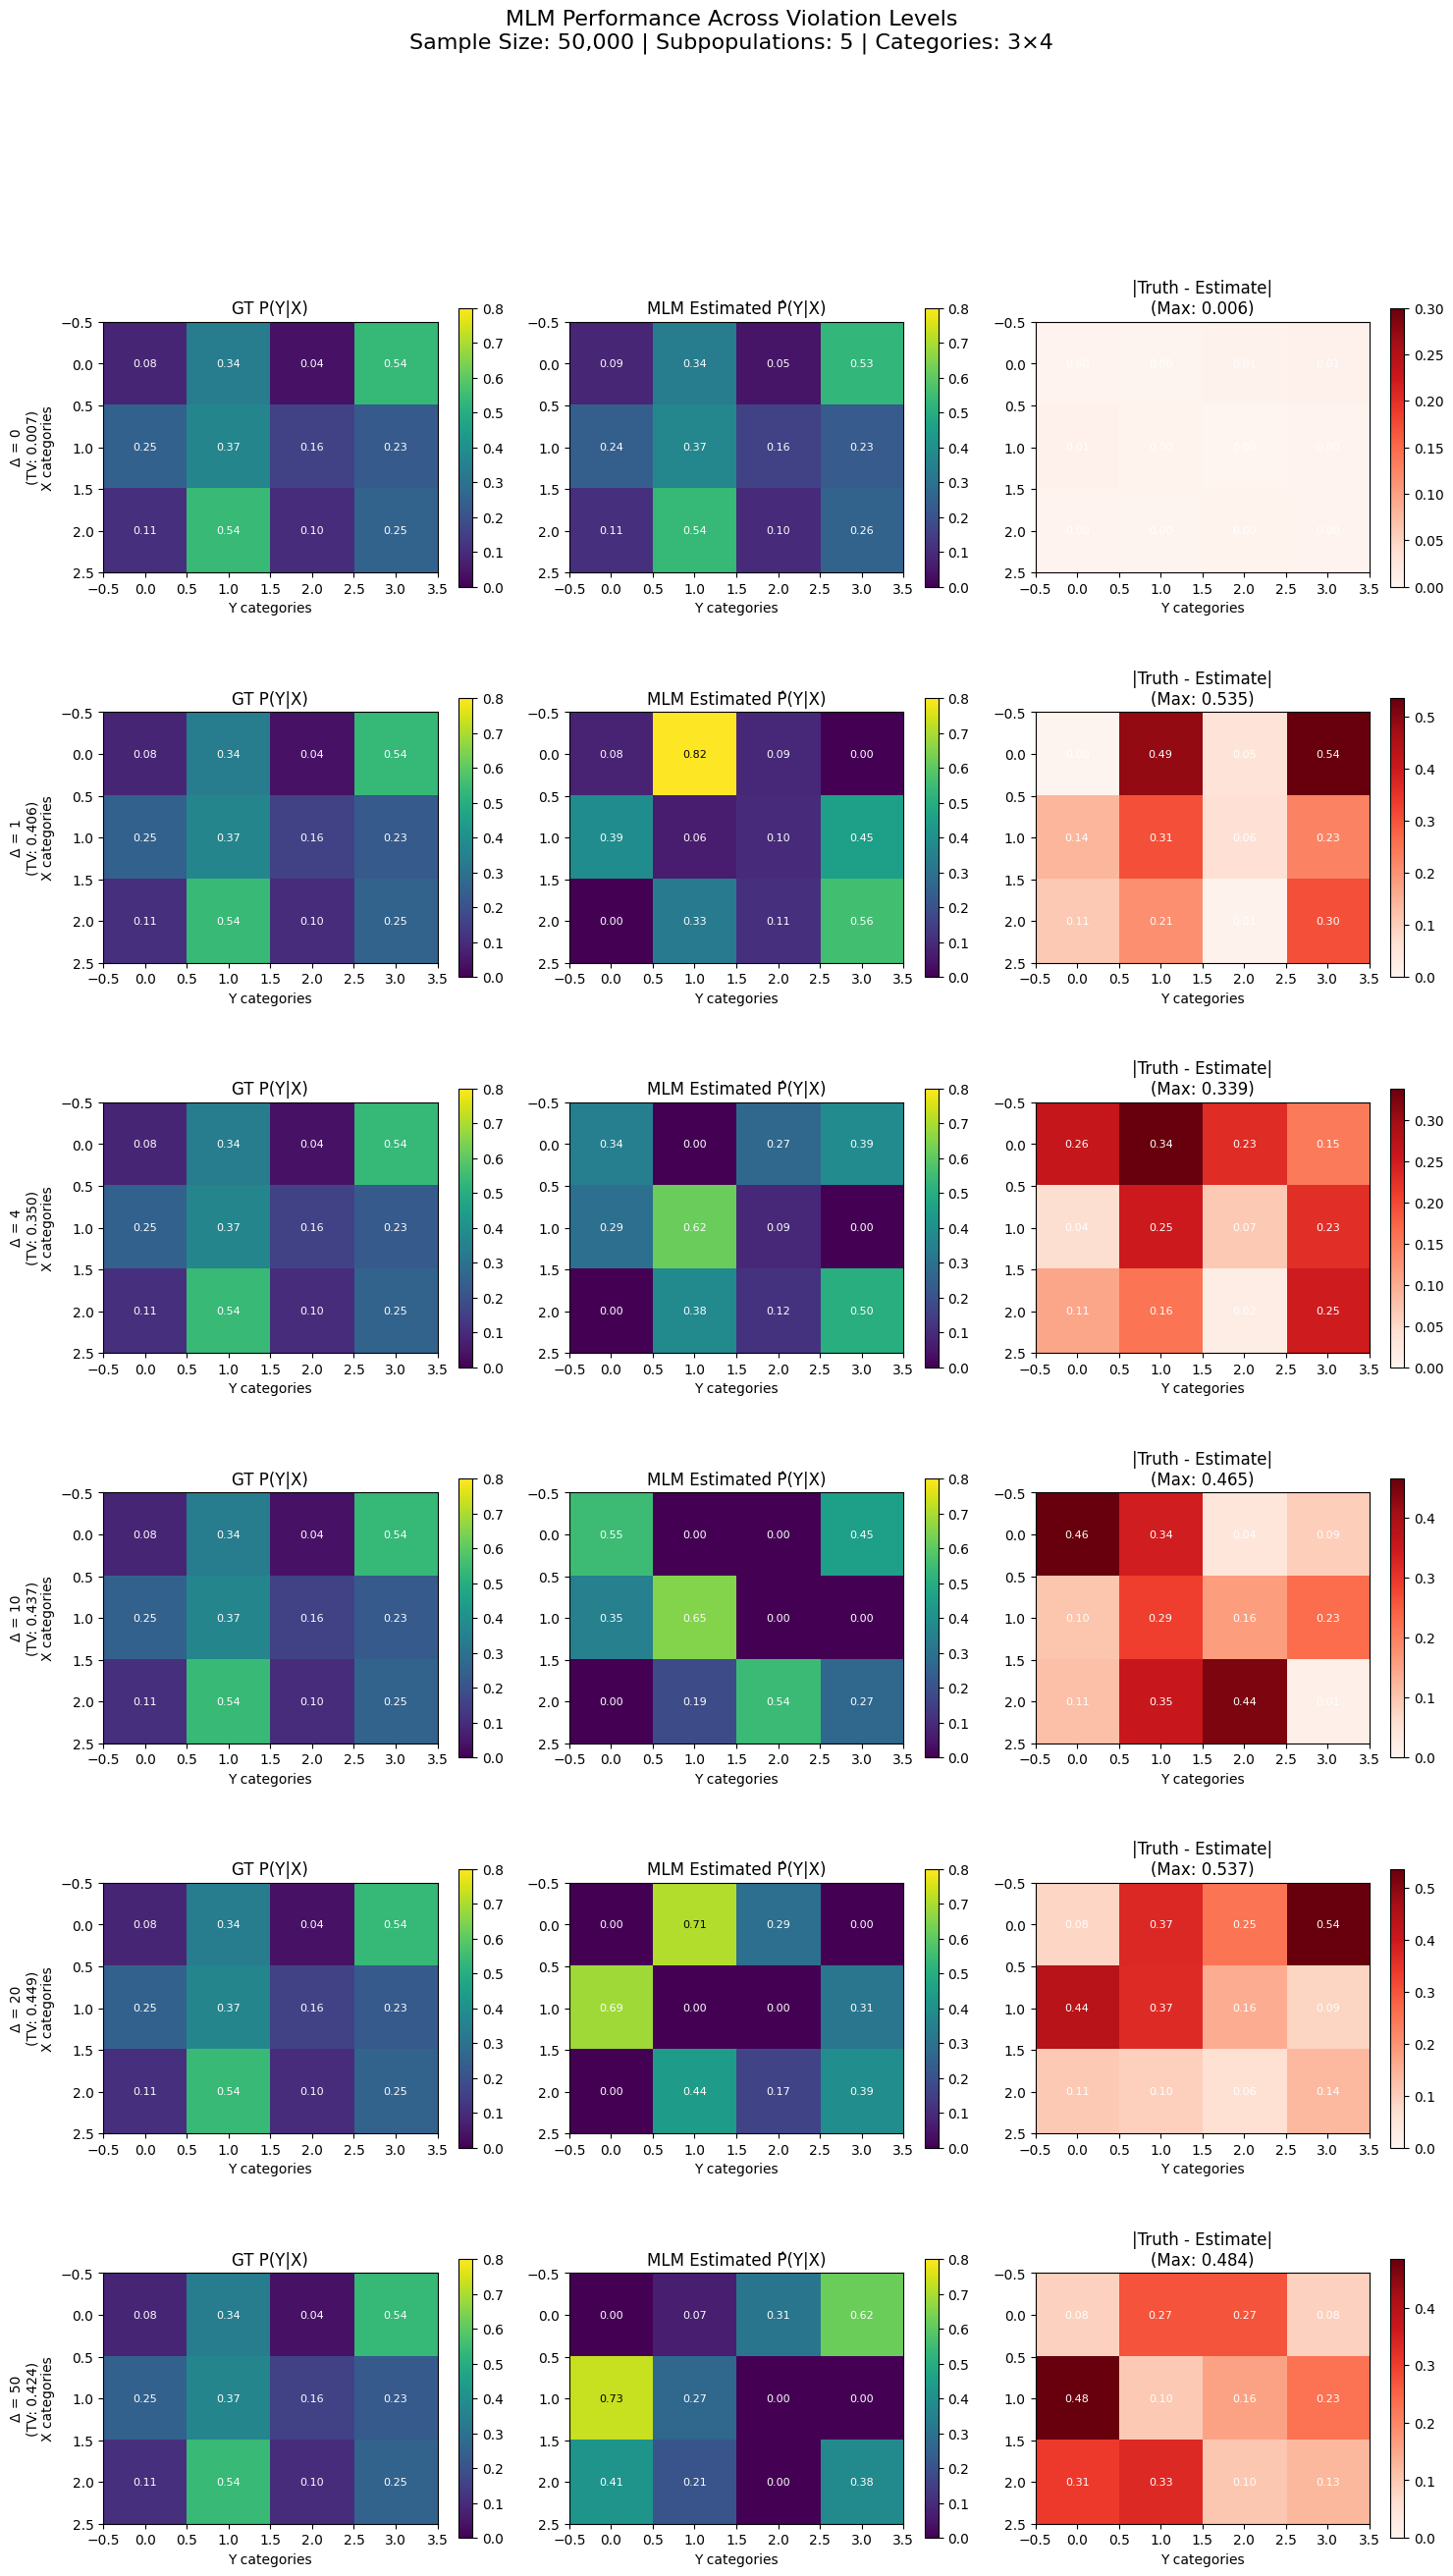

In [33]:

n_samples_viz = 50000  # Sample size for visualization (balance between speed and accuracy)
fig, axes = plt.subplots(len(Delta_values), 3, figsize=(15, 4*len(Delta_values)))
if len(Delta_values) == 1:
    axes = axes.reshape(1, -1)
for i, delta in enumerate(Delta_values):
    PY_XL = PY_XL_dict[delta]
    PX_L = PL_X.T / np.sum(PL_X, 0)[:,None]  # P(X|L) for each subpopulation
    PY_L = np.zeros((num_L, num_Y))
    for l in range(num_L):
        for y in range(num_Y):
            PY_L[l, y] = np.sum(PY_XL[:, y, l] * PX_L[l])  # P(Y|L) = Σ_x P(Y|X,L) * P(X|L)
    viz_rng = np.random.default_rng(42 + i)  # Different seed for each delta for variety
    Nlx = np.array([viz_rng.multinomial(n_samples_viz, px) for px in PX_L])
    Nly = np.array([viz_rng.multinomial(n_samples_viz, py) for py in PY_L])
    qhat, CIs = markovlink.estimates(Nlx, Nly, nsamps=50, verbose=False)
    accuracy = simulations.evaluate_estimation_accuracy(PY_X, qhat, f"delta_{delta}")
    
    im1 = axes[i, 0].imshow(PY_X, vmin=0, vmax=0.8, cmap='viridis') # gt
    axes[i, 0].set_title('GT P(Y|X)', fontsize=12)
    axes[i, 0].set_ylabel(f'Δ = {delta}\n(TV: {accuracy["tv_distance"]:.3f})', fontsize=12)
    im2 = axes[i, 1].imshow(qhat, vmin=0, vmax=0.8, cmap='viridis')
    axes[i, 1].set_title('MLM Estimated P̂(Y|X)', fontsize=12)
    diff = np.abs(PY_X - qhat)
    max_diff = np.max(diff)
    im3 = axes[i, 2].imshow(diff, vmin=0, vmax=max(0.3, max_diff), cmap='Reds')
    axes[i, 2].set_title(f'|Truth - Estimate|\n(Max: {max_diff:.3f})', fontsize=12)
    for j, (ax, im) in enumerate(zip(axes[i], [im1, im2, im3])):
        plt.colorbar(im, ax=ax, shrink=0.8)
        ax.set_xlabel('Y categories', fontsize=10)
        if j == 0:
            ax.set_ylabel(ax.get_ylabel() + '\nX categories', fontsize=10)
        if PY_X.shape[0] <= 5 and PY_X.shape[1] <= 6:  # Only annotate if not too large
            for x in range(PY_X.shape[0]):
                for y in range(PY_X.shape[1]):
                    if j == 0:  # Ground truth
                        val = PY_X[x, y]
                    elif j == 1:  # Estimate
                        val = qhat[x, y]
                    else:  # Difference
                        val = diff[x, y]
                    text_color = 'white' if val < 0.7 else 'black'
                    ax.text(y, x, f'{val:.2f}', ha='center', va='center', 
                            color=text_color, fontsize=8)
plt.tight_layout()
plt.suptitle(f'MLM Performance Across Violation Levels\n' +
             f'Sample Size: {n_samples_viz:,} | Subpopulations: {num_L} | ' +
             f'Categories: {num_X}×{num_Y}', 
             fontsize=16, y=1.1)
plt.show()